# Dog Breed Identification (TF2-Solution)

Determine the breed of a dog in an image

![](https://cdn.shopify.com/s/files/1/0009/1566/9028/products/Dog-breed-list-1a_48eb1174-3812-4ee2-91c7-436609d267b8_2048x.jpg?v=1649426254)

![](https://automaticaddison.com/wp-content/uploads/2019/11/tensorflow_2-1200x600.png)

Training in the CPU is quite slow, but it is still feasible to use a pre-trained network, replace the final layer and train just this last layer. 

Thanks Beluga for your great kernel. This one uses not only the concept but also a lot of the code. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob as glob
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, MaxPooling2D, Activation,Flatten, Dropout, BatchNormalization, MaxPool2D
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,RMSprop
from keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm
import gc
import joblib

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Download Data Set

-- From https://www.kaggle.com/competitions/dog-breed-identification

![](https://opendatascience.com/wp-content/uploads/2018/12/kaggle.png)

In [67]:
## DOWNLOAD DATA SET FROM https://www.kaggle.com/competitions/dog-breed-identification

# !wget -O dog-breed-identification.zip "YOUR_DOWNLOAD_PATH"

In [3]:
# !mkdir kaggle
# !mkdir kaggle/input
# !mkdir kaggle/input/dog-breed-identification

In [4]:
# !unzip dog-breed-identification.zip -d kaggle/input/dog-breed-identification/ >> tmp

# Reading the labels file to get the classes

In [6]:
labels = pd.read_csv('kaggle/input/dog-breed-identification/labels.csv')
labels['new_id'] = labels['id'] + '.jpg'
labels.head()

,id,breed,new_id
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg


In [7]:
classes = list(labels.sort_values(by='breed')['breed'].unique())
classes[:10]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle']

# EDA

In [8]:
print('Total No. of breeds in the dataset :',labels.breed.unique().shape[0])

Total No. of breeds in the dataset : 120


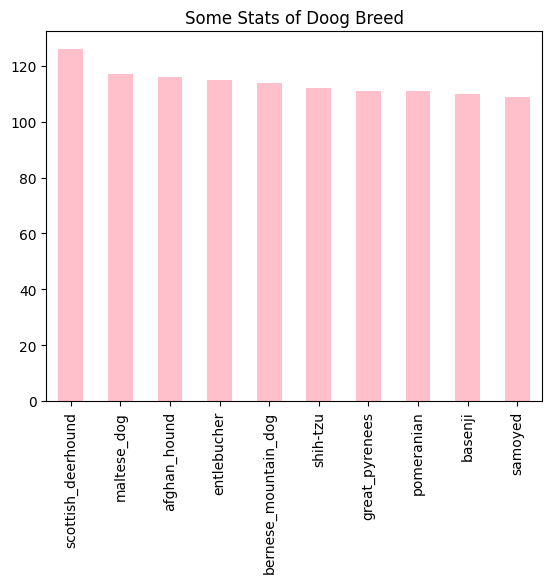

In [72]:
labels.breed.value_counts()[:10].plot(kind='bar',title = 'Some Stats of Doog Breed',color='pink')
plt.show()

In [10]:
value_counts_name = labels.breed.value_counts().index
value_counts = labels.breed.value_counts()
print("The breed with the highest no. of photos is :",value_counts_name[0],
      "\nNo.of Images : ",value_counts[0],
      "\nThe breed with the lowest no. of photos is :",value_counts_name[-1],
      "\nNo.of Images :",value_counts[-1])

The breed with the highest no. of photos is : scottish_deerhound 
No.of Images :  126 
The breed with the lowest no. of photos is : briard 
No.of Images : 66


In [11]:
print(f"Images per breed : {labels.shape[0]/labels.breed.unique().shape[0]}")

Images per breed : 85.18333333333334


In [12]:
labels.isnull().sum().sum()

0

There are 10k plus photos of Dogs that are classified in 120 breeds, this comes down to on average of 85 images of dogs per breed with which we should first try and fit a model, but before that we need to split the training data in train and split and check how the model is performing. 

We can take actions as following:

* Data Augmentation
* Transfer Learning

# Image Generator

In [19]:
def image_generator(ImageShape):
    batch = 32
    datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.2, rotation_range=20,
                                    zoom_range=0.1, width_shift_range=0.2, height_shift_range=0.2,
                                    shear_range=0.1, horizontal_flip=True, fill_mode="nearest")
    
    train = datagen.flow_from_dataframe(dataframe = labels,
                                        x_col = 'new_id',
                                        y_col = 'breed',
                                        target_size = (ImageShape,ImageShape),
                                        directory = 'kaggle/input/dog-breed-identification/train/',
                                        batch_size = batch,
                                        subset = 'training',
                                        class_mode = 'categorical',
                                        shuffle = True, 
                                        seed = 12
    )

    validation = datagen.flow_from_dataframe(dataframe = labels,
                                             x_col = 'new_id',
                                             y_col = 'breed',
                                             target_size = (ImageShape,ImageShape),
                                             directory='kaggle/input/dog-breed-identification/train/',
                                             batch_size = batch ,
                                             shuffle=True,
                                             class_mode='categorical', 
                                             seed = 12, 
                                             subset = 'validation'
    )
    
    return train,validation

In [20]:
GPUS = ["GPU:0","GPU:1"]
strategy = tf.distribute.MirroredStrategy( GPUS )
print('Number of devices: %d' % strategy.num_replicas_in_sync)

Number of devices: 2


# Train Model with Xception

![](https://cdn-images-1.medium.com/max/1600/1*SRBSbojkg48DTUMcP5VVHg.jpeg)

In [41]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)

filename='xcep_log.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [42]:
train_ds,val_ds = image_generator(299)

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


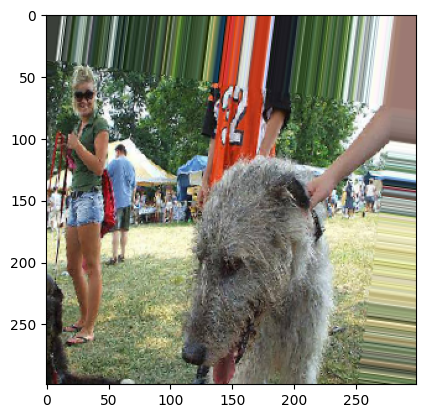

In [51]:
plt.imshow(train_ds[0][0][9])

In [47]:
xcep_model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks = [es, history_logger])with strategy.scope():
    base_model = tf.keras.applications.Xception(include_top = False,weights = 'imagenet',input_shape = (299,299,3))
    base_model.trainable = False
    xcep_model = Sequential()
    xcep_model.add(base_model)
    xcep_model.add(tf.keras.layers.GlobalMaxPooling2D())
    xcep_model.add(Dense(512,activation = 'relu'))
    xcep_model.add(Dropout(0.5))
    xcep_model.add(Dense(120,activation = 'softmax'))
    
    xcep_model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0004))

83683744/83683744 [==============================] - 1s 0us/step


In [50]:
xcep_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_13 (Dense)            (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 120)               61560     
                                                                 
Total params: 21,972,128
Trainable params: 1,110,648
Non-trainable params: 20,861,480
__________________________________

In [53]:
xcep_model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks = [es, history_logger])

Epoch 1/5
256/256 [==============================] - 294s 1s/step - loss: 1.0853 - accuracy: 0.7133 - val_loss: 0.6673 - val_accuracy: 0.8121
Epoch 2/5
256/256 [==============================] - 248s 970ms/step - loss: 0.7966 - accuracy: 0.7734 - val_loss: 0.5751 - val_accuracy: 0.8200
Epoch 3/5
256/256 [==============================] - 249s 973ms/step - loss: 0.7039 - accuracy: 0.7997 - val_loss: 0.5617 - val_accuracy: 0.8351
Epoch 4/5
256/256 [==============================] - 249s 974ms/step - loss: 0.6546 - accuracy: 0.8130 - val_loss: 0.5914 - val_accuracy: 0.8273
Epoch 5/5
256/256 [==============================] - 252s 983ms/step - loss: 0.6034 - accuracy: 0.8227 - val_loss: 0.5561 - val_accuracy: 0.8366


In [54]:
with strategy.scope():
    base_model.trainable = True
    xcep_model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00001))
    
xcep_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_13 (Dense)            (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 120)               61560     
                                                                 
Total params: 21,972,128
Trainable params: 21,917,600
Non-trainable params: 54,528
_____________________________________

In [55]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [56]:
xcep_model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[es, history_logger], batch_size = 64)

Epoch 1/5
256/256 [==============================] - 411s 1s/step - loss: 0.7248 - accuracy: 0.7914 - val_loss: 0.5147 - val_accuracy: 0.8410
Epoch 2/5
256/256 [==============================] - 315s 1s/step - loss: 0.5607 - accuracy: 0.8337 - val_loss: 0.4994 - val_accuracy: 0.8542
Epoch 3/5
256/256 [==============================] - 311s 1s/step - loss: 0.4903 - accuracy: 0.8529 - val_loss: 0.4817 - val_accuracy: 0.8527
Epoch 4/5
256/256 [==============================] - 312s 1s/step - loss: 0.4462 - accuracy: 0.8630 - val_loss: 0.4848 - val_accuracy: 0.8576
Epoch 5/5
256/256 [==============================] - 310s 1s/step - loss: 0.3980 - accuracy: 0.8792 - val_loss: 0.4625 - val_accuracy: 0.8625


In [57]:
xcep_model.save('xcep_model.hdf5')

# Predicting the Outputs on test data

In [59]:
test_images_files_names = os.listdir('kaggle/input/dog-breed-identification/test')
test_df = pd.DataFrame(test_images_files_names, columns=['id'])
test_df.head()

,id
0,86a0fd36e02213745983716ae3e80aef.jpg
1,347947d56fe31407d224ba45199843d1.jpg
2,57c922bbb2b3c863e0888a539b7e70ce.jpg
3,5ccdc606e46085dfa87ff1d4a9cad7e1.jpg
4,449b80248ef1434f00a749fb7fa63dc0.jpg


In [60]:
test_datagen = ImageDataGenerator(rescale= 1./255)
test = test_datagen.flow_from_dataframe(test_df, directory='kaggle/input/dog-breed-identification/test', x_col='id',target_size=(299,299), class_mode=None, batch_size=64, shuffle=False)

Found 10357 validated image filenames.


In [61]:
preds = xcep_model.predict(test)

162/162 [==============================] - 91s 516ms/step


In [ ]:
#

# Predict Unseen Image

![](https://cdn.britannica.com/70/148370-050-87E4E987/Scottish-deerhound.jpg)

In [75]:
# sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"

# image from Google 
sunflower_url = "https://cdn.britannica.com/70/148370-050-87E4E987/Scottish-deerhound.jpg" 
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
print(sunflower_path)

img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=(299, 299)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = xcep_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# for debug the logic
#print(classes)
#print(score)
print()

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)

/root/.keras/datasets/Red_sunflower
1/1 [==============================] - 0s 129ms/step

This image most likely belongs to afghan_hound with a 2.23 percent confidence.
